### 2.a.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_raw = pd.read_csv('diabetes.csv')
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 2.b.

In [3]:
df = df_raw.drop(axis=1, columns=['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Outcome'])
df.head()

,Glucose,BloodPressure,BMI,Age
0,148,72,33.6,50
1,85,66,26.6,31
2,183,64,23.3,32
3,89,66,28.1,21
4,137,40,43.1,33


### 2.c.

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(df)
df_normalized = pd.DataFrame(X_normalized, columns=df.columns)
df_normalized.head()

,Glucose,BloodPressure,BMI,Age
0,0.848324,0.149641,0.204013,1.425995
1,-1.123396,-0.160546,-0.684422,-0.190672
2,1.943724,-0.263941,-1.103255,-0.105584
3,-0.998208,-0.160546,-0.494043,-1.041549
4,0.504055,-1.504687,1.409746,-0.020496


### 2.d.

In [5]:
def euclidean_distance_squared(point1, point2):
    return np.sum((point1 - point2)**2)

def initialize_membership_matrix(n_samples, n_clusters):
    U = np.random.rand(n_samples, n_clusters)
    row_sums = U.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    U = U / row_sums
    U[np.isnan(U)] = 1.0 / n_clusters
    return U

def update_centroids(X, U, m, n_clusters):
    Um = U ** m
    denominator = Um.sum(axis=0, keepdims=True).T
    denominator[denominator == 0] = 1e-10
    centroids = (Um.T @ X) / denominator
    return centroids

def update_membership_matrix(X, centroids, m):
    n_samples = X.shape[0]
    n_clusters = centroids.shape[0]
    power_val = 2.0 / (m - 1.0)
    
    distances = np.sqrt(((X[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
    distances = np.fmax(distances, 1e-10)
    
    U_new = np.zeros((n_samples, n_clusters))
    
    zero_mask = distances < 1e-10
    has_zero = zero_mask.any(axis=1)
    
    if has_zero.any():
        U_new[has_zero] = zero_mask[has_zero].astype(float)
        row_sums = U_new[has_zero].sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        U_new[has_zero] = U_new[has_zero] / row_sums
    
    no_zero_mask = ~has_zero
    if no_zero_mask.any():
        dists_subset = distances[no_zero_mask]
        ratio = dists_subset[:, :, np.newaxis] / dists_subset[:, np.newaxis, :]
        U_new[no_zero_mask] = 1.0 / (ratio ** power_val).sum(axis=2)
    
    return U_new

def fuzzy_c_means_model(X, n_clusters, m=2.0, max_iters=100, tolerance=1e-5):
    if isinstance(X, pd.DataFrame):
        X_np = X.values
    elif isinstance(X, np.ndarray):
        X_np = X
    else:
        raise TypeError("Input X must be a pandas DataFrame or a numpy array.")
        
    n_samples, _ = X_np.shape
    
    if m <= 1:
        raise ValueError("'m' (fuzziness) must be greater than 1.")
        
    U = initialize_membership_matrix(n_samples, n_clusters)
    
    for i in range(max_iters):
        U_old = U.copy()
        centroids = update_centroids(X_np, U, m, n_clusters)
        U = update_membership_matrix(X_np, centroids, m)
        
        change = np.linalg.norm(U - U_old)
        if change < tolerance:
            break
            
    centroids = update_centroids(X_np, U, m, n_clusters)
    
    return U, centroids

In [6]:
PLOTSDIR = 'plots/'

In [7]:
results = {}
m_values = [2, 4]
n_clusters = 3

for m_val in m_values:
    print(f"Running Fuzzy C-Means with m={m_val}...")
    U, centroids = fuzzy_c_means_model(df_normalized, n_clusters=n_clusters, m=m_val, max_iters=100, tolerance=1e-5)
    
    results[m_val] = {
        'U': U,
        'centroids': centroids,
        'hard_labels': np.argmax(U, axis=1)
    }
    
    print(f"  Converged successfully")
    print(f"  Cluster Distribution: {np.bincount(results[m_val]['hard_labels'])}")
    print()

print()

Running Fuzzy C-Means with m=2...
  Converged successfully
  Cluster Distribution: [268 274 226]

Running Fuzzy C-Means with m=4...
  Converged successfully
  Cluster Distribution: [361 329  78]




### 2.e.

Analysis for m=2:
  Silhouette Score: 0.2001
  Cluster sizes: [268 274 226]


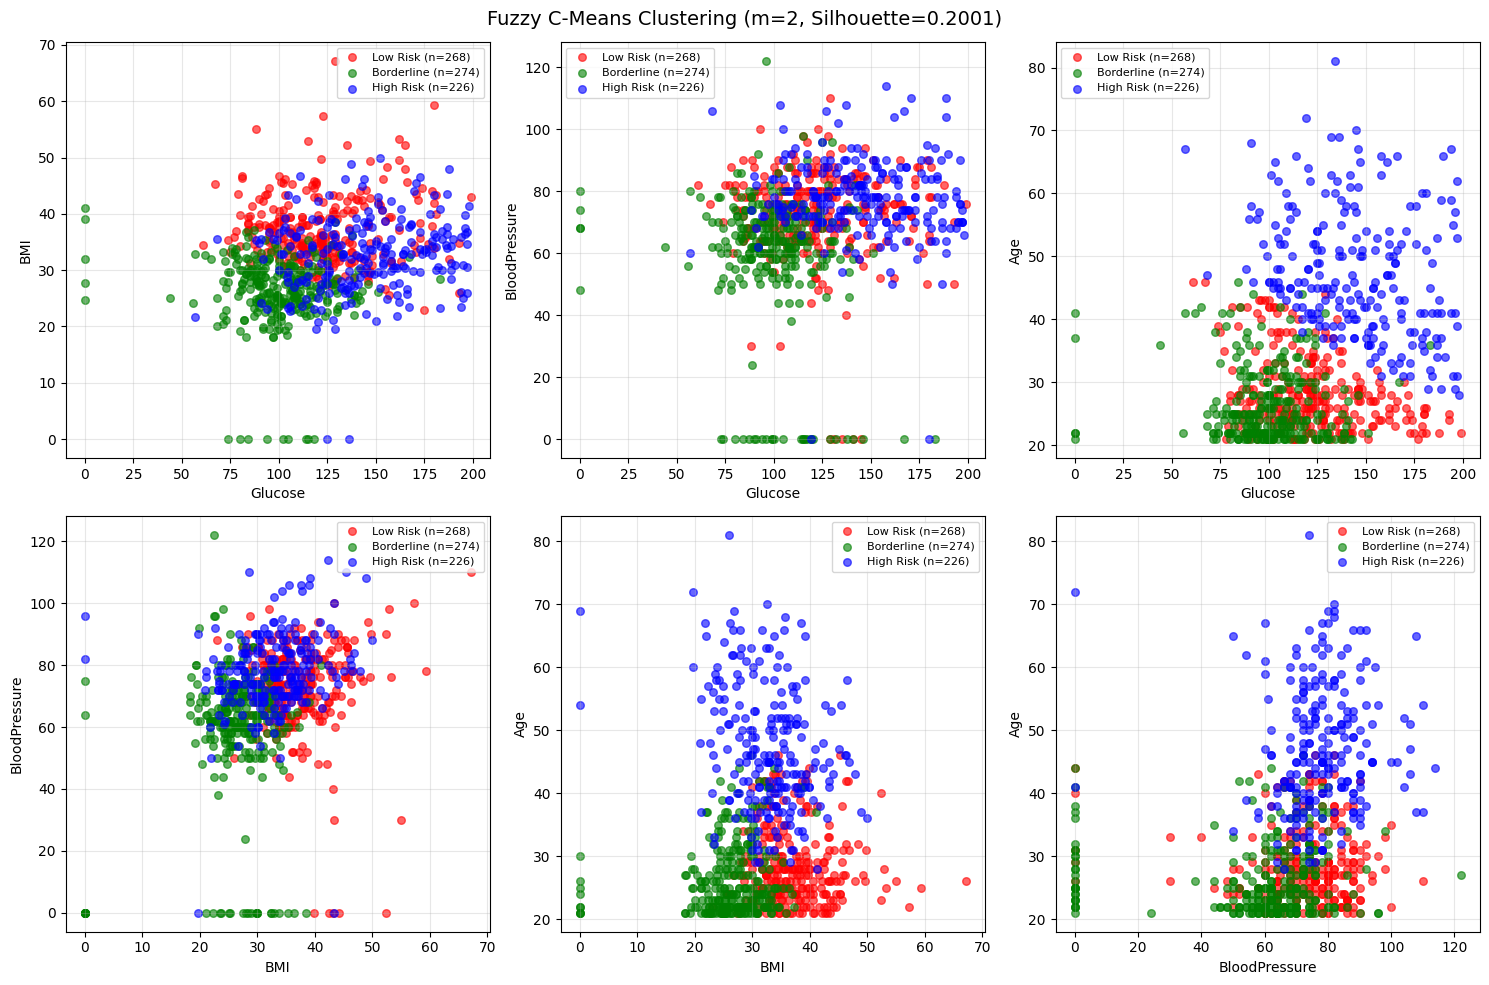

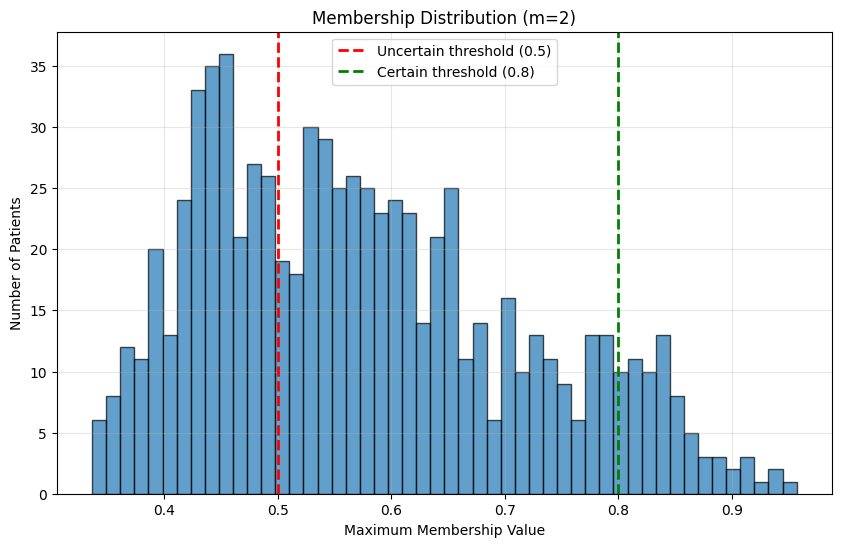


Analysis for m=4:
  Silhouette Score: 0.0564
  Cluster sizes: [361 329  78]


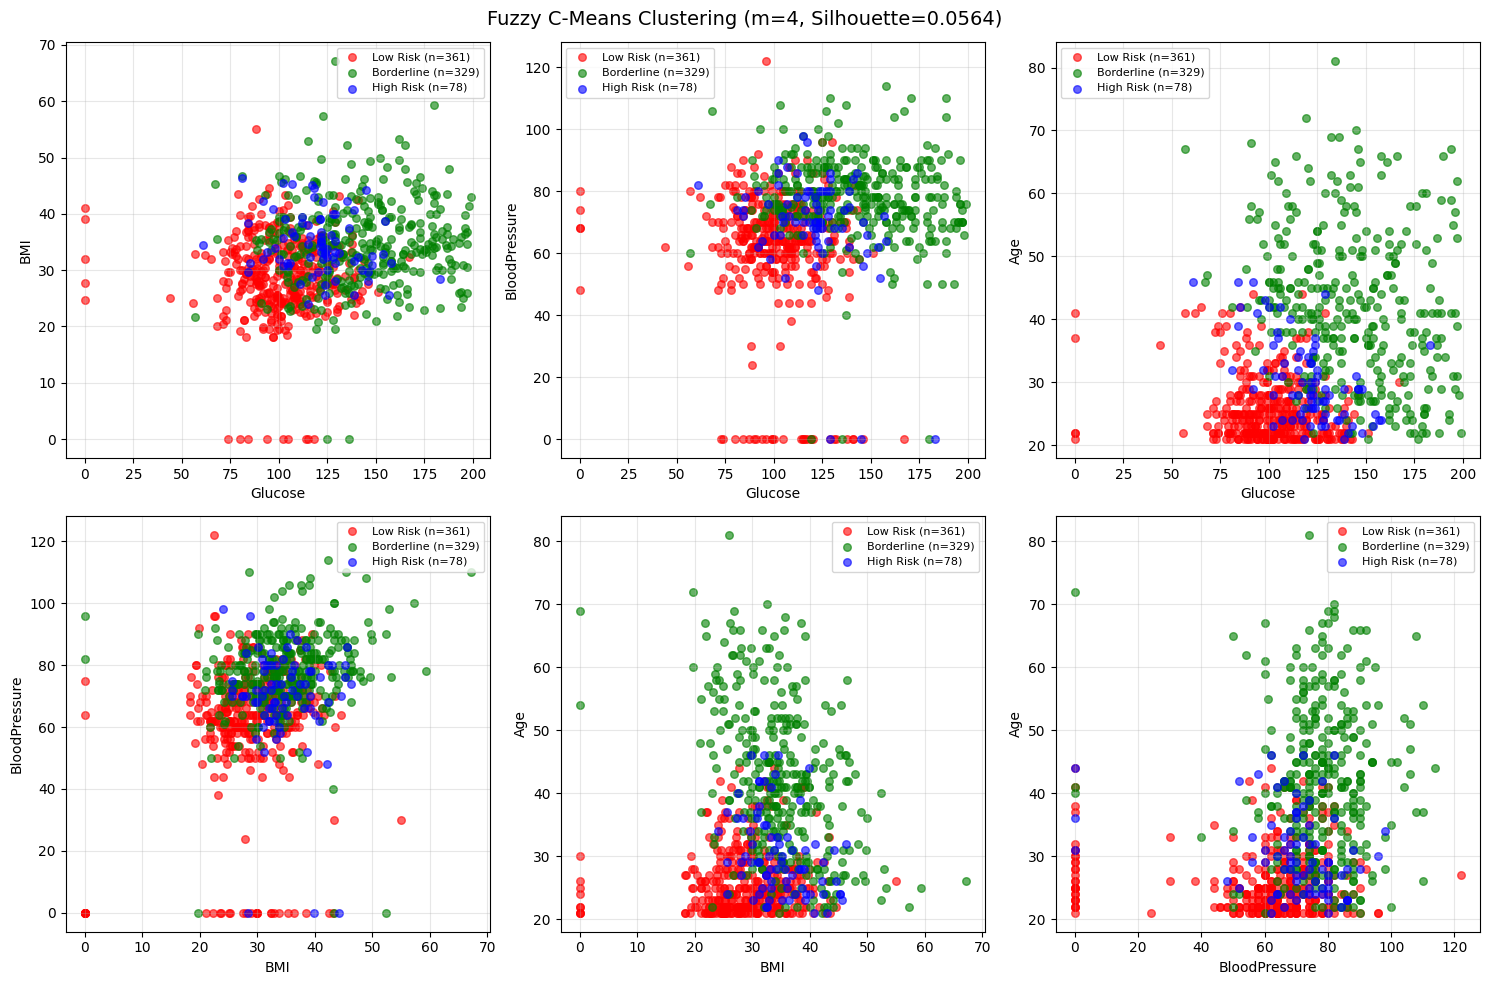

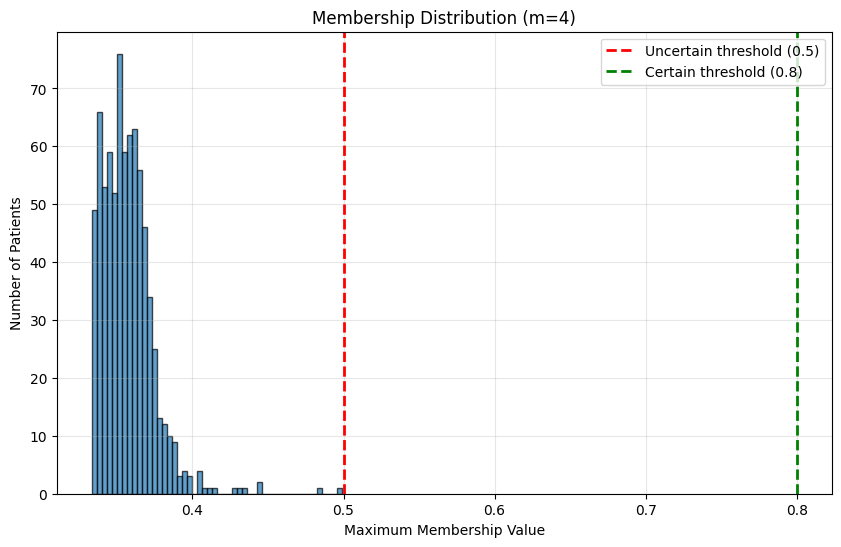


BEST MODEL: m=2 with Silhouette Score = 0.2001



In [8]:
for m_val in m_values:
    print(f"Analysis for m={m_val}:")
    
    U = results[m_val]['U']
    hard_labels = results[m_val]['hard_labels']
    
    silhouette_scores = []
    for i in range(len(X_normalized)):
        cluster_label = hard_labels[i]
        same_cluster = hard_labels == cluster_label
        
        if same_cluster.sum() > 1:
            same_pts = X_normalized[same_cluster]
            a = np.mean(np.sqrt(((X_normalized[i] - same_pts)**2).sum(axis=1)))
        else:
            a = 0
        
        b_vals = []
        for other_label in range(n_clusters):
            if other_label != cluster_label:
                other_mask = hard_labels == other_label
                if other_mask.sum() > 0:
                    other_pts = X_normalized[other_mask]
                    b_vals.append(np.mean(np.sqrt(((X_normalized[i] - other_pts)**2).sum(axis=1))))
        
        b = min(b_vals) if b_vals else 0
        
        if max(a, b) > 0:
            silhouette_scores.append((b - a) / max(a, b))
        else:
            silhouette_scores.append(0)
    
    avg_silhouette = np.mean(silhouette_scores)
    results[m_val]['silhouette'] = avg_silhouette
    results[m_val]['silhouette_scores'] = silhouette_scores
    
    print(f"  Silhouette Score: {avg_silhouette:.4f}")
    print(f"  Cluster sizes: {np.bincount(hard_labels)}")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Fuzzy C-Means Clustering (m={m_val}, Silhouette={avg_silhouette:.4f})', fontsize=14)
    
    feature_pairs = [
        ('Glucose', 'BMI'),
        ('Glucose', 'BloodPressure'),
        ('Glucose', 'Age'),
        ('BMI', 'BloodPressure'),
        ('BMI', 'Age'),
        ('BloodPressure', 'Age')
    ]
    
    colors = ['red', 'green', 'blue']
    cluster_names = ['Low Risk', 'Borderline', 'High Risk']
    
    for idx, (feat1, feat2) in enumerate(feature_pairs):
        ax = axes[idx // 3, idx % 3]
        
        for cluster_id in range(n_clusters):
            mask = hard_labels == cluster_id
            ax.scatter(
                df[feat1][mask],
                df[feat2][mask],
                c=colors[cluster_id],
                label=f'{cluster_names[cluster_id]} (n={mask.sum()})',
                alpha=0.6,
                s=30
            )
        
        ax.set_xlabel(feat1)
        ax.set_ylabel(feat2)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTSDIR + f'2e_clusters_m{m_val}.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    max_memberships = U.max(axis=1)
    plt.hist(max_memberships, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(0.5, color='r', linestyle='--', linewidth=2, label='Uncertain threshold (0.5)')
    plt.axvline(0.8, color='g', linestyle='--', linewidth=2, label='Certain threshold (0.8)')
    plt.xlabel('Maximum Membership Value')
    plt.ylabel('Number of Patients')
    plt.title(f'Membership Distribution (m={m_val})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(PLOTSDIR + f'2e_membership_dist_m{m_val}.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print()

best_m = max(results.keys(), key=lambda k: results[k]['silhouette'])
print(f"BEST MODEL: m={best_m} with Silhouette Score = {results[best_m]['silhouette']:.4f}")
print()

### 2.f.

In [9]:
for m_val in m_values:
    print(f"Cluster Centroids for m={m_val}:")
    
    centroids_norm = results[m_val]['centroids']
    centroids_denorm = scaler.inverse_transform(centroids_norm)
    
    print(f"{'Cluster':<15} {'Glucose':<15} {'BMI':<15} {'BloodPressure':<15} {'Age':<15}")
    
    for i, centroid in enumerate(centroids_denorm):
        cluster_name = ['Low Risk', 'Borderline', 'High Risk'][i]
        print(f"{cluster_name:<15} {centroid[0]:<15.2f} {centroid[1]:<15.2f} {centroid[2]:<15.2f} {centroid[3]:<15.2f}")
    
    print()
    
    print("Normalized Centroids (z-scores):")
    print(f"{'Cluster':<15} {'Glucose':<15} {'BMI':<15} {'BloodPressure':<15} {'Age':<15}")
    
    for i, centroid in enumerate(centroids_norm):
        cluster_name = ['Low Risk', 'Borderline', 'High Risk'][i]
        print(f"{cluster_name:<15} {centroid[0]:<15.4f} {centroid[1]:<15.4f} {centroid[2]:<15.4f} {centroid[3]:<15.4f}")
    
    print()

Cluster Centroids for m=2:
Cluster         Glucose         BMI             BloodPressure   Age            
Low Risk        120.96          71.11           34.98           30.15          
Borderline      103.60          62.85           27.72           26.95          
High Risk       141.60          75.77           33.20           44.15          

Normalized Centroids (z-scores):
Cluster         Glucose         BMI             BloodPressure   Age            
Low Risk        0.0021          0.1036          0.3786          -0.2628        
Borderline      -0.5412         -0.3236         -0.5423         -0.5354        
High Risk       0.6479          0.3444          0.1529          0.9282         

Cluster Centroids for m=4:
Cluster         Glucose         BMI             BloodPressure   Age            
Low Risk        116.41          67.70           31.35           31.39          
Borderline      127.87          71.40           32.90           36.18          
High Risk       118.71         

### 2.g.

In [10]:
U_best = results[best_m]['U']
hard_labels_best = results[best_m]['hard_labels']
centroids_best = scaler.inverse_transform(results[best_m]['centroids'])

np.random.seed(42)
random_indices = np.random.choice(len(df), 10, replace=False)

print(f"{'Patient':<10} {'Glucose':<10} {'BMI':<10} {'BP':<10} {'Age':<10} {'Assigned':<15} {'Low Risk':<12} {'Borderline':<12} {'High Risk':<12} {'Interpretation'}")
print("-" * 140)

for idx in random_indices:
    patient_data = df.iloc[idx]
    memberships = U_best[idx]
    assigned_cluster = hard_labels_best[idx]
    cluster_names = ['Low Risk', 'Borderline', 'High Risk']
    
    max_membership = memberships.max()
    if max_membership >= 0.8:
        certainty = "High confidence"
    elif max_membership >= 0.5:
        certainty = "Moderate confidence"
    else:
        certainty = "Uncertain"
    
    sorted_memberships = np.sort(memberships)[::-1]
    if sorted_memberships[0] - sorted_memberships[1] < 0.2:
        certainty += ", borderline"
    
    print(f"{idx:<10} {patient_data['Glucose']:<10.1f} {patient_data['BMI']:<10.1f} {patient_data['BloodPressure']:<10.1f} {patient_data['Age']:<10.1f} "
          f"{cluster_names[assigned_cluster]:<15} {memberships[0]:<12.4f} {memberships[1]:<12.4f} {memberships[2]:<12.4f} {certainty}")

print()
print("Clinical Insights:")
print("-" * 80)
print("• Membership > 0.8: Strong classification confidence")
print("• Membership 0.5-0.8: Moderate confidence, patient shows mixed characteristics")
print("• Membership < 0.5: Uncertain, patient falls between multiple risk categories")
print("• Close memberships (<0.2 difference): Patient at boundary between risk groups")
print()

Patient    Glucose    BMI        BP         Age        Assigned        Low Risk     Borderline   High Risk    Interpretation
--------------------------------------------------------------------------------------------------------------------------------------------
668        98.0       34.0       58.0       43.0       Low Risk        0.3781       0.3186       0.3033       Uncertain, borderline
324        112.0      35.7       75.0       21.0       Low Risk        0.6361       0.2674       0.0965       Moderate confidence
624        108.0      30.8       64.0       21.0       Borderline      0.2520       0.6931       0.0549       Moderate confidence
690        107.0      24.6       80.0       34.0       Borderline      0.2926       0.4994       0.2080       Uncertain
473        136.0      29.9       90.0       50.0       High Risk       0.1638       0.1051       0.7311       Moderate confidence
204        103.0      37.7       72.0       55.0       High Risk       0.2869       0.1871  

### 2.h.

In [11]:
uncertain_mask = U_best.max(axis=1) <= 0.5
certain_mask = U_best.max(axis=1) > 0.5
uncertain_patients = np.where(uncertain_mask)[0]

print(f"Threshold for uncertain clustering: Maximum membership ≤ 0.5")
print(f"Number of uncertain patients: {uncertain_mask.sum()} ({(uncertain_mask.sum()/len(df)*100):.2f}%)")
print()

if uncertain_mask.sum() > 0:
    print("Sample of uncertain patients:")
    print("-" * 120)
    print(f"{'Patient':<10} {'Glucose':<10} {'BMI':<10} {'BP':<10} {'Age':<10} {'Low Risk':<12} {'Borderline':<12} {'High Risk':<12} {'Max':<10}")
    print("-" * 120)
    
    sample_uncertain = uncertain_patients[:min(10, len(uncertain_patients))]
    for idx in sample_uncertain:
        patient_data = df.iloc[idx]
        memberships = U_best[idx]
        print(f"{idx:<10} {patient_data['Glucose']:<10.1f} {patient_data['BMI']:<10.1f} {patient_data['BloodPressure']:<10.1f} {patient_data['Age']:<10.1f} "
              f"{memberships[0]:<12.4f} {memberships[1]:<12.4f} {memberships[2]:<12.4f} {memberships.max():<10.4f}")
    
    print()
    print("Interpretation:")
    print("These patients exhibit characteristics that don't clearly align with any single")
    print("risk category, suggesting they may be transitioning between risk levels or have")
    print("atypical clinical profiles requiring individualized assessment.")
    print()

Threshold for uncertain clustering: Maximum membership ≤ 0.5
Number of uncertain patients: 276 (35.94%)

Sample of uncertain patients:
------------------------------------------------------------------------------------------------------------------------
Patient    Glucose    BMI        BP         Age        Low Risk     Borderline   High Risk    Max       
------------------------------------------------------------------------------------------------------------------------
2          183.0      23.3       64.0       32.0       0.3104       0.2847       0.4049       0.4049    
4          137.0      43.1       40.0       33.0       0.4400       0.2656       0.2944       0.4400    
7          115.0      35.3       0.0        29.0       0.3415       0.3979       0.2606       0.3979    
9          125.0      0.0        96.0       54.0       0.2860       0.3462       0.3679       0.3679    
11         168.0      38.0       74.0       34.0       0.3663       0.1387       0.4950       0.49

### 2.i.

1. NUMBER OF PATIENTS BY CLUSTERING CERTAINTY:
--------------------------------------------------------------------------------
   Uncertain (max membership ≤ 0.5): 276 patients (35.94%)
   Certain (max membership ≥ 0.8): 492 patients (64.06%)
   Moderate (0.5 < max membership < 0.8): 0 patients (0.00%)

2. CLINICAL PARAMETERS COMPARISON:
--------------------------------------------------------------------------------
Parameter            Uncertain Mean       Certain Mean         Difference           % Difference   
-----------------------------------------------------------------------------------------------
Glucose              122.25               120.13               2.12                 1.77           %
BMI                  32.65                31.62                1.03                 3.25           %
BloodPressure        65.46                71.15                -5.70                -8.01          %

Standard Deviations:
---------------------------------------------------------

C:\Users\Vemor\AppData\Local\Temp\ipykernel_14092\415974058.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([uncertain_data, certain_data], labels=['Uncertain', 'Certain'])
C:\Users\Vemor\AppData\Local\Temp\ipykernel_14092\415974058.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([uncertain_data, certain_data], labels=['Uncertain', 'Certain'])
C:\Users\Vemor\AppData\Local\Temp\ipykernel_14092\415974058.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([uncertain_data, certain_data], labels=['Uncertain', 'Certain'])


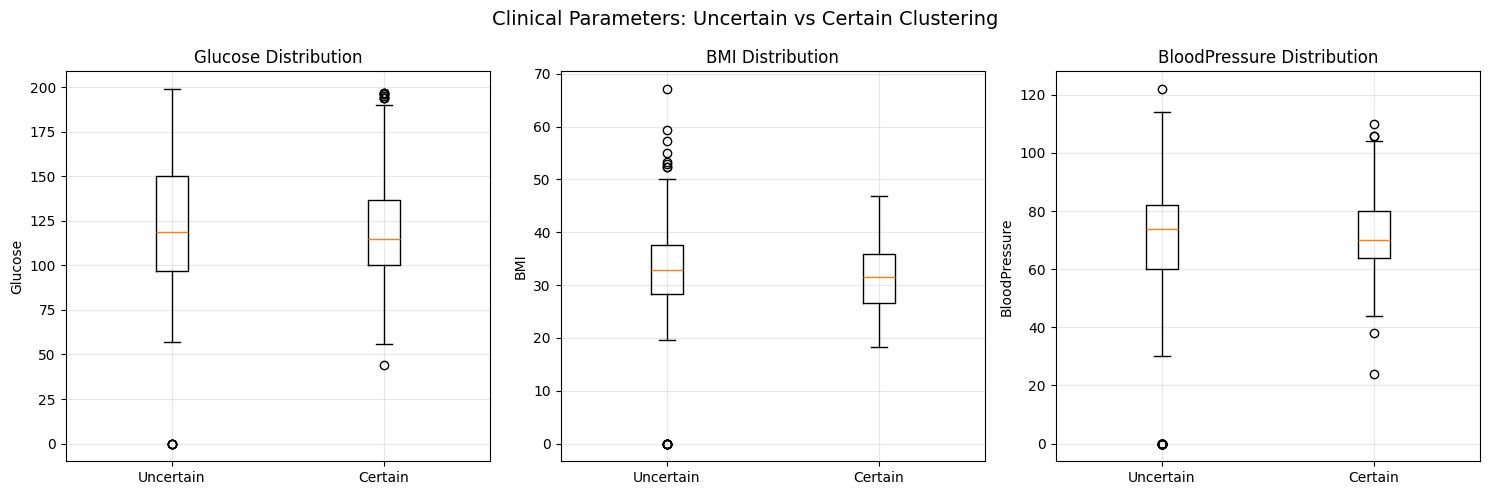

KEY FINDINGS:
--------------------------------------------------------------------------------
• Uncertain patients have higher Glucose (2.12 units, 1.8%)
• Uncertain patients have higher BMI (1.03 units, 3.2%)
• Uncertain patients have lower BloodPressure (5.70 units, 8.0%)

• Uncertain patients show 32.6% more variability in Glucose
• Uncertain patients show 59.9% more variability in BMI
• Uncertain patients show 144.5% more variability in BloodPressure



In [12]:
print("1. NUMBER OF PATIENTS BY CLUSTERING CERTAINTY:")
print("-" * 80)
print(f"   Uncertain (max membership ≤ 0.5): {uncertain_mask.sum()} patients ({(uncertain_mask.sum()/len(df)*100):.2f}%)")
print(f"   Certain (max membership ≥ 0.8): {certain_mask.sum()} patients ({(certain_mask.sum()/len(df)*100):.2f}%)")
print(f"   Moderate (0.5 < max membership < 0.8): {len(df) - uncertain_mask.sum() - certain_mask.sum()} patients "
      f"({((len(df) - uncertain_mask.sum() - certain_mask.sum())/len(df)*100):.2f}%)")
print()

print("2. CLINICAL PARAMETERS COMPARISON:")
print("-" * 80)

if uncertain_mask.sum() > 0 and certain_mask.sum() > 0:
    uncertain_avg = df.iloc[uncertain_mask][['Glucose', 'BMI', 'BloodPressure']].mean()
    certain_avg = df.iloc[certain_mask][['Glucose', 'BMI', 'BloodPressure']].mean()
    uncertain_std = df.iloc[uncertain_mask][['Glucose', 'BMI', 'BloodPressure']].std()
    certain_std = df.iloc[certain_mask][['Glucose', 'BMI', 'BloodPressure']].std()
    
    print(f"{'Parameter':<20} {'Uncertain Mean':<20} {'Certain Mean':<20} {'Difference':<20} {'% Difference':<15}")
    print("-" * 95)
    
    for param in ['Glucose', 'BMI', 'BloodPressure']:
        diff = uncertain_avg[param] - certain_avg[param]
        pct_diff = (diff / certain_avg[param]) * 100
        print(f"{param:<20} {uncertain_avg[param]:<20.2f} {certain_avg[param]:<20.2f} {diff:<20.2f} {pct_diff:<15.2f}%")
    
    print()
    print("Standard Deviations:")
    print("-" * 95)
    print(f"{'Parameter':<20} {'Uncertain Std':<20} {'Certain Std':<20} {'Variability Ratio':<20}")
    print("-" * 95)
    
    for param in ['Glucose', 'BMI', 'BloodPressure']:
        ratio = uncertain_std[param] / certain_std[param]
        print(f"{param:<20} {uncertain_std[param]:<20.2f} {certain_std[param]:<20.2f} {ratio:<20.2f}")
    
    print()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Clinical Parameters: Uncertain vs Certain Clustering', fontsize=14)
    
    parameters = ['Glucose', 'BMI', 'BloodPressure']
    
    for idx, param in enumerate(parameters):
        ax = axes[idx]
        
        uncertain_data = df.iloc[uncertain_mask][param]
        certain_data = df.iloc[certain_mask][param]
        
        ax.boxplot([uncertain_data, certain_data], labels=['Uncertain', 'Certain'])
        ax.set_ylabel(param)
        ax.set_title(f'{param} Distribution')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTSDIR + '2i_uncertain_vs_certain.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("KEY FINDINGS:")
    print("-" * 80)
    
    for param in ['Glucose', 'BMI', 'BloodPressure']:
        diff = uncertain_avg[param] - certain_avg[param]
        if abs(diff) > 0.1:
            direction = "higher" if diff > 0 else "lower"
            print(f"• Uncertain patients have {direction} {param} ({abs(diff):.2f} units, {abs(diff/certain_avg[param]*100):.1f}%)")
    
    print()
    for param in ['Glucose', 'BMI', 'BloodPressure']:
        ratio = uncertain_std[param] / certain_std[param]
        if ratio > 1.1:
            print(f"• Uncertain patients show {(ratio-1)*100:.1f}% more variability in {param}")
        elif ratio < 0.9:
            print(f"• Certain patients show {(1-ratio)*100:.1f}% more variability in {param}")

print()